In [24]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline



Let's generate some data according to an underlying model. Weight is a function of height and age.

We construct 10 data points, random heights, random ages, and weights according to the model with added normally distributed error.

In [335]:
#Relationship 30*height + 1*age = weight
n=100

heights = np.random.normal(5.25, 0.3, n)
ages = np.random.randint(10, 60, n)

weights = 30*heights + 1*ages + np.random.normal(0,10,n)

This is the augmented matrix, I made it big

In [336]:
augmented_matrix = np.vstack([heights, ages, weights]).T
augmented_matrix[:10,:]

array([[   5.20494096,   34.        ,  188.61537316],
       [   5.35513542,   46.        ,  208.14207843],
       [   5.10578176,   34.        ,  187.98618985],
       [   4.97472887,   37.        ,  188.42753671],
       [   5.82311292,   17.        ,  199.55527867],
       [   5.10889309,   31.        ,  181.00034759],
       [   4.98501414,   19.        ,  161.15744291],
       [   5.17766109,   33.        ,  183.40218255],
       [   4.73348642,   57.        ,  189.0095191 ],
       [   5.65184583,   20.        ,  191.15023973]])

If we take each row in the augmented matrix as a parametric equation:


In [337]:
for i in range(3):
    print("{:0.2f}x + {:0.2f}y = {:0.2f}".format(*augmented_matrix[i]))
print('etc...')

5.20x + 34.00y = 188.62
5.36x + 46.00y = 208.14
5.11x + 34.00y = 187.99
etc...



we can plot each in ℝ<sup>2</sup>. Since there is error, instead of the solution to the problem being at the intersection of all of the lines, the solution is the point closest to all of the lines (least squares distance)

Notice the general intersection of the lines is around x=30 and y=1, which are the coefficients in the original model

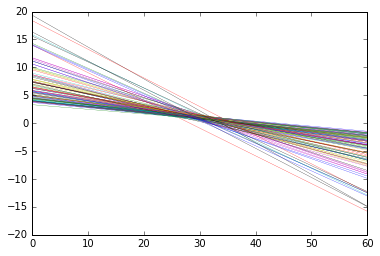

In [338]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.linspace(0, 60)
for i in range(n):
    ys = (augmented_matrix[i,2]-(augmented_matrix[i,0]*xs))/augmented_matrix[i,1]
    plt.plot(xs,ys, linewidth=0.25)
plt.show()

To illustrate that this works I solve the model/matrix equation in an absurdly roundabout way, by actually finding a point in ℝ<sup>2</sup> that is closest to all the lines.

      fun: 0.28470596286058225
 hess_inv: array([[ 58.332269  , -12.04798006],
       [-12.04798006,   2.80369909]])
      jac: array([  1.78627670e-05,   9.42721963e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 180
      nit: 12
     njev: 42
   status: 2
  success: False
        x: array([ 29.54325663,   1.01257693])


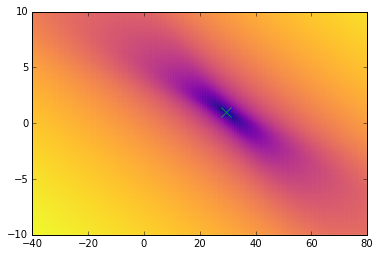

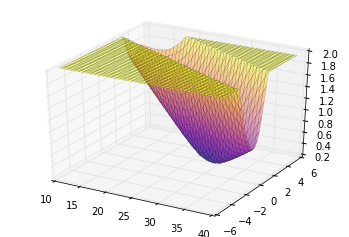

In [313]:
a, b, c = np.split(augmented_matrix, 3, axis=1)
def distance(x, y):
    """
    Calculate distance from point x,y to all lines defined by rows of augmented matrix
    """
    distances = np.abs(a*x+b*y-c)/np.sqrt(a**2+b**2)
    return distances.mean()

def distance_(xy):
    """
    Same as distance but takes a vector to work with minimize()
    """
    x,y=xy
    distances = np.abs(a*x+b*y-c)/np.sqrt(a**2+b**2)
    return distances.mean()

#Minimize distance from point to all lines (this gives us the solution)
minimized=minimize(distance_, (0., 0.))
print(minimized)


#Lets do some plots of distance, first up, heatmapish thing of mean distance to all lines for a big range

xmin, xmax = -40, 80
ymin, ymax = -10, 10
X = np.linspace(xmin, xmax, 200)
Y = np.linspace(ymin, ymax, 200)
X, Y = np.meshgrid(X, Y)
C=np.vectorize(distance)(X, Y)
lC = np.log(C)
plt.pcolormesh(X, Y, lC, cmap = plt.get_cmap('plasma'), shading='gouraud')

#Plot both optimized answer and model coefficients on plot, they should be near identical
plt.scatter(30, 1, marker='x', c=(0, 0, 1, 0.5), s=100)
plt.scatter(*minimized.x, marker='x', c=(0, 1, 0, 0.5), s=100)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()


#Now lets plot a 3d plot of coefficient values vs distance from all row-defined vector-form lines
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
theCM = plt.get_cmap('plasma')
theCM._init()
alphas = np.abs(np.linspace(0.5, 0.5, theCM.N))
theCM._lut[:-3,-1] = alphas

xmin, xmax = 10, 40
ymin, ymax = -5, 5
X = np.linspace(xmin, xmax, 200)
Y = np.linspace(ymin, ymax, 200)
X, Y = np.meshgrid(X, Y)
C=np.vectorize(distance)(X, Y)
ax.plot_surface(X, Y, np.clip(C, 0, 2), rstride=5, cstride=5, cmap = theCM, linewidth=0.1)
plt.show()

Scatterplot of data with line representing the underlying model

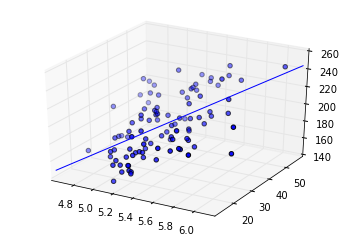

In [327]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

minmax_x = (augmented_matrix[:,0].min(), augmented_matrix[:,0].max())
minmax_y = (augmented_matrix[:,1].min(), augmented_matrix[:,1].max())
xs = np.linspace(minmax_x[0],minmax_x[1], 10)
ys = np.linspace(minmax_y[0],minmax_y[1], 10)
zs = 30*xs+1*ys
ax.plot(xs, ys, zs)
ax.set_xlim(minmax_x[0],minmax_x[1],)
ax.set_ylim(minmax_y[0],minmax_y[1],)
ax.scatter(augmented_matrix[:,0],augmented_matrix[:,1],augmented_matrix[:,2])
plt.show()

If you remove a bit of data, instead of plotting the rows as lines if you remove the weight column you get a series of planes in 3d. If you imagine projecting these onto the xy=weight plane for each row, you end up with the lines from the previous plot. I feel like there must be something interesting here if instead of projecting and finding the pseudo-intersection you find the line that hits closest to the lines in 3d. Maybe this is representing the solution to some more complex model where the coefficients you multiply age/height by can change depending on scale? 

I mostly thought it was a neat fuzzy rectangular prism plot and looked cool.

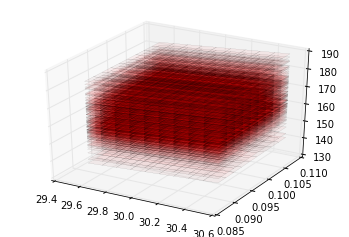

In [340]:
#165z=4.75x+19y

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = np.linspace(29.5, 30.5, 10)
ys = np.linspace(0.09, 0.11, 10)
X, Y = np.meshgrid(xs, ys)
for i in range(100):
    h = augmented_matrix[i,0]
    a = augmented_matrix[i,1]
    w = augmented_matrix[i,2]
    Z = (h*X + a*Y)
    ax.plot_surface(X, Y, Z, rstride=1,cstride=1, color=(1,0,0,0.05), linewidth=0.05)
plt.show()